#### Vít Škvára - Samoorganizace a dolování dat/Self-organization and data mining

# Kernel methods for multiple-instance learning problem

In this protocol, we explore the possibily of using kernel methods, namely smallest enclosing hypersphere, for the task of anomaly detection under the multiple-instance learning paradigm.

## Multiple-instance learning (MIL)

In multiple-instance learning (MIL), the problem of supervised binary classification is made more difficult for the learner due to a number of reasons. Firstly, instead of having a set of instances (feature vectors) labeled as negative or positive, a number of _bags_ of instances is received, where the whole bags are labeled as positive or negative. Every bag consists of a (possibly different) number of instances whose individual labels are not known. The common conception is that a bag is labeled negative if all instances in it are negative, but if even a single instance is positive, then the label of the bag is also positive. Secondly, the ratio of negative to positive instances in a bag can be arbitrarily high. In real-world problems however, this presumption can be violated and positive and negative bags may be generated from entirely different sources. 

Our motivation comes from the area of malware detection in computers connected to a network whose activity is supervised. In such a case, the communication of every computer with the outside world (using a HTTP protocol) goes through a common hub. The observer, for a limited time frame, collects all HTTP requests of the computers in the network. From each request, we substract a number of features (e.g. bytes sent and received, request lenght in ms). A collection of such instances for one computer creates a bag. Additionaly, some computers are known to be infected with malware that communicates with the Internet. Their bags are then labeled as positive and together with bags of some uninfected computers compose a training dataset. Presumably, positive bags should contain a number of positive instances - requests created by the malware. 

## Kernel theory basics

Firstly, we will give a brief introduction to kernel methods and the smallest hypersphere algorithm that will be used to detect outliers or anomalies. A kernel is a mapping
\begin{equation}
    \kappa(x,y) = \langle \phi(x), \phi(y) \rangle
\end{equation}
that encodes data $x,y \in \mathcal{X}$ to feature space $\mathcal{F}$ using a scalar product of an embedding map 
\begin{equation}
    \phi:\mathcal{X} \rightarrow \mathcal{F}.
\end{equation}

The trick of kernel methods is that for a training dataset $X= \lbrace x_1, x_2, \dots, x_m \rbrace$, they are able to use standar linear machine learning techniques on the richer feature space $\mathcal{F}$ without directly computing the potentially computationally demanding mapping $\phi(x_i), i = 1, 2, \dots, m$. Instead, it is sufficient to obtain the kernel matrix $G$, which satistfies 
\begin{equation}
    G_{ij} = \kappa(x_i,x_j) = \langle \phi(x_i), \phi(x_j) \rangle.
\end{equation}
This matrix is symmetric and enables us to use a large number of classical algorithms in the feature space.

The quadratic kernel is one of the simplest. It is defined as 
\begin{equation}
    \kappa(x,y) = \langle x, y \rangle^2
\end{equation}
and its corresponding feature map for $\mathcal{X} = \mathbb{R}^2$ is 
\begin{equation}
    \phi(x) = (x_1^2, x_2^2, \sqrt{2}x_1x_2) 
\end{equation}
embeds the original samples to feature space $\mathcal{F} = \mathbb{R}^3$.



## Experiment 1

We will implement the smallest enclosing sphere algorithm and test it on a simple benchmark problem. 

Firstly, we generate the data and create the kernel.

In [1]:
# here, the required libraries are loaded
using Convex, SCS # for optimization
using ClobberingReload # for deprecation warnings supression
using PyPlot # for plots

We generate a training and a testing dataset in $\mathbb{R}^2$.

In [15]:
m = 2 # problem dimension
c_data = [1,4] # the data will be offset by this
n_train = 20 # no training samples
X_train = randn(2,n_train) .+ c_data

n_test = 10
X_test = randn(2,n_test) .+ c_data
A = randn(2, n_test)*10 .+ c_data 
X_test = cat(2, X_test, A);

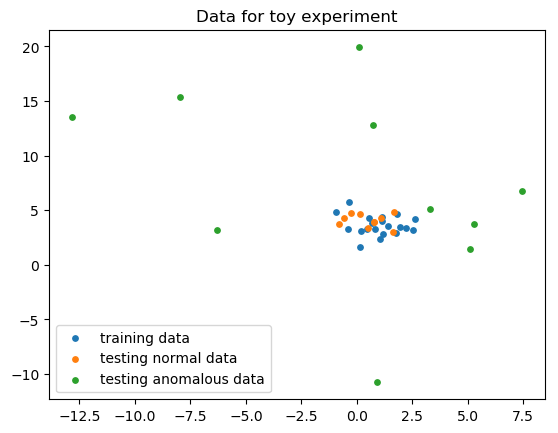

In [16]:
f = figure()
ss = 15
scatter(X_train[1,:], X_train[2,:], s=ss, label = "training data")
scatter(X_test[1,1:n_test], X_test[2,1:n_test], s = ss, 
    label = "testing normal data")
scatter(X_test[1,n_test+1:end], X_test[2,n_test+1:end], s = ss,
    label = "testing anomalous data")
legend()
title("Data for toy experiment");

We will use the quadratic kernel as the generating function has quite a simple form. We will use the form with offset
\begin{equation}
    \kappa(x,y) = (\langle x, y \rangle + c)^2
\end{equation}
which has a feature map
\begin{equation}
    \varphi(x) = \left( x_1^2, \ldots, x_m^2, \sqrt{2} x_1 x_{2}, \ldots, \sqrt{2} x_1 x_m, \sqrt{2} x_2 x_3, \ldots, \sqrt{2} x_2 x_m, \ldots, \sqrt{2} x_{m-1} x_{m}, \sqrt{2c} x_1, \ldots, \sqrt{2c} x_m, c \right)
\end{equation}
We know that the resulting feature space $\mathcal{F}$ has dimension ${m+2\choose 2} = 6$ for $m=2$. 

Below, the feature map for a quadratic kernel and a sample space of arbitrary dimension is implemented.

In [30]:
"""
    quadmap(x, c = 0.0)

Is the feature map for quadratic kernel.
"""
function quadmap{T<:Real}(x::AbstractArray{T,1}, c = 0.0)
    m = length(x)
    nq = binomial(m+2,2)
    
    # decrease the resulting dimension if c is zero
    if c == 0
        nq -= (m+1)
    end
    
    # create the resulting array
    res = zeros(nq)
    
    # first the solo quadratic coefficients
    res[1:m] = x.^2
    
    # now the cross-quadratics
    k = 1+m
    for i in 1:m
        for j in 1:(m-i) 
           res[k] = sqrt(2)*x[i]*x[j]
            k += 1
        end
    end
    
    if c != 0
        # now the linear elements
        for i in 1:m
           res[k] = sqrt(2*c)*x[i]
            k += 1
        end

        # now the final constant
        res[end] = c
    end
    
    return res
end

# version for 2D arrays
quadmap{T<:Real}(x::AbstractArray{T,2}, c = 0.0) = 
    mapslices(y -> quadmap(y,c), x, 1)

quadmap (generic function with 6 methods)

Below here, the type representing the quadratic kernel is implemented along with a constructor. The constructor is called with data $X$ and offset $c$ (which has a default value of 0). It computes and stores the kernel matrix and initializes the feature map. Also, an object of type `quadkernel` can be called directly as `quadkernel(x,y)` or `quadkernel(x)` to obtain the value for vectors `x,y`.

Implementation remark: for quadratic kernel and $m<3$, the kernel matrix may not be numerically positive definite, so we add a small number to its diagonal. This has the same effect as adding noise to training samples.

In [5]:
# abstract kernel type
abstract type kernel
end

# quadratic kernel type
struct quadkernel <: kernel
    X # the data matrix
    km # kernel matrix
    ϕ # feature map
    c
end

# constructor
quadkernel(X, c=0) = quadkernel(X, 
    (X'*X .+ c).^2 + eye(size(X,2))*1e-12, # here the noise is added 
    x -> quadmap(x,c), # the feature map is fixed with given c
    c)

# overloaded for direct calling
(qk::quadkernel)(x,y) = (x'*y + qk.c).^(2)
(qk::quadkernel)(x) = qk(x,x)

Now we initialize a new object of type `quadkernel` with the training data. We set $c=0$. Also, we visualize the kernel matrix after initialization.

In [17]:
qk = quadkernel(X_train)
qk.km

20×20 Array{Float64,2}:
 244.523   149.883   213.446   125.618   …  383.853   390.087   36.5796 
 149.883   121.338   167.545   108.278      225.766   265.489   30.5686 
 213.446   167.545   232.098   148.551      323.094   373.547   42.0711 
 125.618   108.278   148.551    97.862      187.283   228.11    27.4565 
 225.467   153.257   215.665   131.641      348.813   373.559   37.869  
 100.845    66.4832   93.8809   56.7019  …  156.702   165.201   16.3688 
 220.887   237.967   319.535   224.216      316.497   439.873   61.6483 
 252.324   135.172   195.672   109.448      403.198   383.874   32.425  
 249.443   143.731   206.203   118.613      394.848   389.26    34.8072 
 262.923   192.086   268.153   167.695      402.429   447.601   47.8555 
 182.52    108.882   155.557    90.6437  …  287.578   288.354   26.4836 
 247.95    202.46    279.31    180.989      372.965   440.682   51.0519 
 297.969   221.418   308.531   194.023      454.894   510.561   55.2674 
 110.84    111.386   150.53

## The smallest enclosing hypersphere algorithm

The idea of the algorithm is finding a smallest enclosing hypersphere of the training dataset $X$ in feature space $\mathcal{F}$ that is defined by center $c \in \mathcal{F}$ and radius $r\in \mathbb{R}$. This translates to a nonlinear optimization problem for an unknown weight vector $\alpha \in \mathbb{R}^n$ defined as
$$
    \max_{\alpha} W(\alpha) = \alpha^T \text{diag}(G) - \alpha^T G\alpha
$$
$$
    \text{s.t.} \sum_{i=1}^n \alpha_i = 1, \alpha_i \geq 0, i = 1, \dots, n
$$
where $\text{diag}(G)$ is a vector containing the diagonal elements of $G$.

Let $\alpha^*$ denote the found optimal solution. Then the following holds
$$
    r^* = \sqrt{W(\alpha^{*})}
$$
$$
    c^* = \sum_{i=1}^n \alpha_i^* \phi(x_i)
$$
where $r^*, c^*$ are the radius and center of the smallest sphere that contains all the training data.

For a new sample $x$, the testing function that determines whether the point lies inside or outside the sphere has the following  form
$$
    f(x) = \kappa(x,x) - 2 \sum_{i=1}^n \alpha_i^* \kappa(x_i,x) + D,
$$
$$
    D = \alpha^{*T} G \alpha^* - r^{*2}.
$$
If $f(x) \geq 0$, then the sample lies inside the sphere, otherwise it is outside.

Note that for the computation of the testing function, the exact form  of the feature map $\phi(x)$ is not needed as it is not required here.


The type `kernel_sh` contains the basic building blocks for the smallest enclosing hypersphere algorithm. It contains the kernel (which is again a structure containing kernel matrix, feature map and parameters of the kernel) and parameters of the algorithm: $\alpha^*, r^*, D$ and $c^*$. The constructor is called using a structure of type `kernel`.

In [34]:
# kernelized smallest hypersphere for anomaly detection
mutable struct kernel_sh
    k::kernel # kernel
    α # alpha
    r # hypersphere radius
    D # D constant
    c # hypersphere center
    opt::Bool # was the solution already found?
end

# constructor
kernel_sh(k::kernel) = 
    kernel_sh(k, Array{Float64,1}([]), NaN, NaN, NaN, false)

kernel_sh

The following functions and methods for the `kernel_sh` type implement  $W(\alpha)$, testing function $f(x)$ and the optimization method to find $\alpha^*$. To solve the maximisation problem with linear constraints we use the `Convex` package with `SCS - Splitting Convex Solver`.

In [98]:
W(α,gm) = diag(gm)'*α - sum(gm.*(α*α'))
W(ksh::kernel_sh) = W(ksh.α, ksh.k.km)

function find_sphere!(ksh::kernel_sh)
    # this is the optimization part using Convex and SCS packages
    # setup the variables, objective and constraints
    n = size(ksh.k.km,1)
    α = Variable(n, Positive())
    dkm = diag(ksh.k.km)'
    km = ksh.k.km
    objective = dkm*α - quadform(α, km)
    constraints = [sum(α) == 1.0]
    problem = maximize(objective, constraints) 
    # solve
    no_warnings() do
        solve!(problem)
    end
    # if succesfully solved, extract and round the optimal solution
    if problem.status == :Optimal
        ksh.α = round.(problem.solution.primal[1:n], 3)
        ksh.opt = true
    else
        error("Optimal α not found!")
    end
    
    # compute the radius
    ksh.r = sqrt(W(ksh))
    # compute D for the anomaly score function
    ksh.D = ksh.α'*ksh.k.km*ksh.α - ksh.r^2
    # compute the center - but we don't really need this
    # but for the 2D case it is possible
    if !(ksh.k.ϕ == nothing)
        ksh.c = ksh.k.ϕ(ksh.k.X)*ksh.α
    end
    
    return 
end

"""
    anomaly_score(ksh::kernel_sh, x)

This computes the anomaly score/testing function given a kernel 
hypersphere and a sample x.
"""
function anomaly_score(ksh::kernel_sh, x)
    if ksh.opt
        return ksh.k(x) - 2*ksh.α'*ksh.k(ksh.k.X, x) + ksh.D
    else
        warn("The optimum value was not yet found!")
        return NaN
    end
end

anomaly_score

Initialize an instance of the `kernel_sh` type using the previously created quadratic kernel and compute the enclosing hypersphere. The output of the splitting conic solver is printed.

In [99]:
# initialize the object
ksh = kernel_sh(qk)
# and find the optimal alpha
find_sphere!(ksh)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 466
eps = 1.00e-04, alpha = 1.80, max_iters = 20000, normalize = 1, scale = 5.00
Variables n = 23, constraints m = 47
Cones:	primal zero / dual free vars: 2
	linear vars: 21
	soc vars: 24, soc blks: 2
Setup time: 8.35e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  2.03e-05 
   100|      inf       inf      -nan      -inf      -inf       inf  3.28e-04 
   200|      inf       inf      -nan      -inf      -inf       inf  6.34e-04 
   300|      inf       inf    

Let us check the results.

In [100]:
println("α opt: $(ksh.α)")
println("r opt: $(ksh.r)")
println("c opt: $(ksh.c)")

α opt: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.433, 0.0, 0.155, 0.0, 0.412]
r opt: 15.469045128980744
c opt: [1.144, 18.1603, 1.61785]


We can see that only 3 training samples have non-zero $\alpha$ coefficients. We call them the support vectors. Since the dimensionality of the feature space is 3, this confirms the fact that the smallest enclosing hypersphere can be determined using at most these 3 vectors that lie on the surface of thy hypersphere.

Let us also check how the testing data is score according to the testing function (first 10 testing vectors are normal data).

In [37]:
for i in 1:size(X_test,2)
    as = anomaly_score(ksh, X_test[:,i])
    println("f(x_$(i)): $(as)")
end

f(x_1): -107.56871841900013
f(x_2): -192.65530441932995
f(x_3): -221.2382630622789
f(x_4): -193.34412962718093
f(x_5): -211.61645919765166
f(x_6): -214.71703292984833
f(x_7): -226.27585934941047
f(x_8): -222.52154454739102
f(x_9): -119.1830538281747
f(x_10): -211.8432951572507
f(x_11): 9462.33864844386
f(x_12): 1207.4340333165349
f(x_13): 82309.21510802883
f(x_14): 114659.12043270057
f(x_15): 8258.657103937823
f(x_16): 2228.51417730123
f(x_17): 21254.53689777251
f(x_18): 424.71488435575384
f(x_19): 724.4817468380677
f(x_20): 144725.7458960742


Now, let us visualize the result in the feature space.

In [59]:
"""
    sphere(r,c,T)

Returns an array containing the coordinates of a sphere 
with radius r and center c discretized at T^2 points.
"""
function sphere(r,c,T)
    θ = linspace(0,pi, T)
    ϕ = linspace(0, 2*pi, T)
    sph = zeros(3,T*T)

    k = 1
    for t1 in 1:T
        for t2 in 1:T
            sph[1,k] = r*sin(θ[t1])*sin(ϕ[t2])
            sph[2,k] = r*sin(θ[t1])*cos(ϕ[t2])
            sph[3,k] = r*cos(θ[t1])
            k+=1
        end
    end
    return sph .+ c
end

sphere

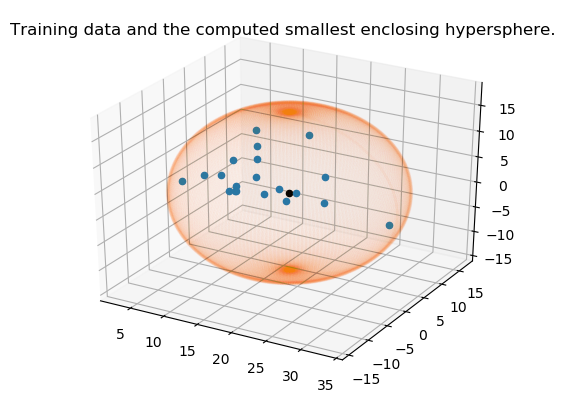

PyObject Text(0.5,0.92,'Training data and the computed smallest enclosing hypersphere.')

In [71]:
# X_train transformed into feature space
phiX_train = ksh.k.ϕ(X_train)
scatter3D(phiX_train[2,:], phiX_train[1,:], phiX_train[3,:],
    depthshade = false)
scatter3D(ksh.c[2,:], ksh.c[1,:], ksh.c[3,:], 
    depthshade = false, c = "black")
ses = sphere(ksh.r, ksh.c, 200)
scatter3D(ses[2,:], ses[1,:], ses[3,:], s= 3, alpha=0.01)
title("Training data and the computed smallest enclosing hypersphere.")

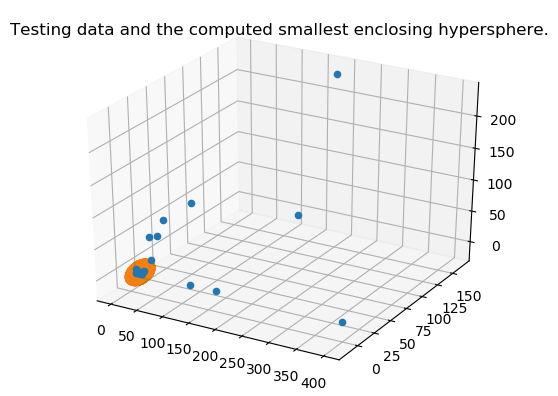

PyObject Text(0.5,0.92,'Testing data and the computed smallest enclosing hypersphere.')

In [72]:
phiX_test = ksh.k.ϕ(X_test)
scatter3D(phiX_test[2,:], phiX_test[1,:], phiX_test[3,:],
    depthshade = false)
scatter3D(ksh.c[2,:], ksh.c[1,:], ksh.c[3,:], 
    depthshade = false, c = "black")
ses = sphere(ksh.r, ksh.c, 200)
scatter3D(ses[2,:], ses[1,:], ses[3,:], s= 3, alpha=0.01)
title("Testing data and the computed smallest enclosing hypersphere.")